<a href="https://colab.research.google.com/github/sugatoray/stackoverflow/blob/master/src/answers/Q_72193393/function_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Minimizing on a Metric Landscape that is NOT Condusive to using `scipy.optimize.minimize`

- https://stackoverflow.com/questions/72193393/find-the-value-of-variables-to-maximize-return-of-function-in-python#72193393

This [question](https://stackoverflow.com/questions/72193393/find-the-value-of-variables-to-maximize-return-of-function-in-python#72193393) is where all this started from. Optimizing algorithms (such as in libraries: scipy.optimize, cvxpy, optuna, hyperopt) basically traverse a metric landscape (typically known as *loss-landscape*) alike you would walk on a certain landscape. 

Let's first try and visualize the essence of how these function-optimization algorithms work mostly. Consider you are an explorer, walking on a vast landscape. You are tasked to find the lowest (or, the highest) point in a given space of the landscape. How will you find it?

Say, it is the highest point. And say the topography around you rather flat. Perhaps your task is way easier now. As you can visually inspect and find the highest point in the landscape. But that requires you to have visibility: daylight, clear visibility to miles, no mirages, etc. So, if you were to find the highest point in a valley, in pitch dark, without any night-vision capabilities, what are your chances to look at that highest point? Not so easy anymore, eh?! Now, consider that you are trying to find the lowest point in the landscape. If you have a rather flat topography, vision is not going to be much helpful here either, as anything depressed down from the ground level at a distance, may not be clearly visible, until you have come closer to the spot. Let's change the scenario a bit: consider you are standing inside a valley. So, there are lots of hills and mountains around you. Obviously, you cannot possibly see the lowest point, unless you could fly up and look down. Wait, not so fast! Even if you have a bird's eyeview (aireal photoshots) of the said region, that does not give you a metric to come up with precise measurements of the depth of each point on the aireal photoshot; unless, the various points are differently colored based on their altitude (or, depth). So, in order to find how high or how deep a spot is on the landscape, you need a measure: a function that evaluates a metric. You can have more than one, but you certainly need at least one.

## The Face-punch

The following code snippet is an example of someone trying to find the lowest point on a certain metric-landscape. The function `myFunc` is what evaluates the metric, given four numeric inputs. It's not important what those quantities stand for; rather we are going to observe the behaviour of the problem and it's objective.

In [2]:
import pandas as pd
import numpy as np
from scipy import optimize

cols = {
    'Dividend2': [9390, 7448, 177], 
    'Probability': [341, 376, 452], 
    'EV': [0.53, 0.60, 0.55], 
    'Dividend': [185, 55, 755], 
    'EV2': [123, 139, 544],
}

df = pd.DataFrame(cols)

def myFunc(params):
    """myFunc metric."""
    (ev, bv, vc, dv) = params
    df['Number'] = np.where(df['Dividend2'] <= vc, 1, 0) \
                    + np.where(df['EV2'] <= dv, 1, 0)
    df['Return'] =  np.where(
        df['EV'] <= ev, 0, np.where(
            df['Probability'] >= bv, 0, df['Number'] * df['Dividend'] - (vc + dv)
        )
    )
    return -1 * (df['Return'].sum())

b1 = [(0.2,4), (300,600), (0,1000), (0,1000)]
start = [0.2, 600, 1000, 1000]
result = optimize.minimize(fun=myFunc, bounds=b1, x0=start)
print(result)

      fun: -0.0
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 3., 3.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 35
      nit: 2
   status: 0
  success: True
        x: array([2.e-01, 6.e+02, 0.e+00, 0.e+00])


So, it seems at first glance that the code executed properly and did not throw any error. It says it had success in finding the minimized solution.

```sh
      fun: -0.0
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 3., 3.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL' # 💡
     nfev: 35
      nit: 2
   status: 0
  success: True
        x: array([2.e-01, 6.e+02, 0.e+00, 0.e+00]) # 🔥
```

A close observation reveals that the solution (see 🔥) is no different from the starting point `[0.2, 600, 1000, 1000]`. So, seems like nothing really happened and the algorithm just finished prematurely?!!

Now look at the `message` above (see 💡). If we run a google search on this, you could find some of the following.

- **Summary**
  > `b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'`
  >
  > If the loss-landscape does not have a smoothely changing topography, the gradient descent algorithms will soon find that from one iteration to the next, there isn't much change happening and hence, will terminate further seeking. Also, if the loss-landscape is rather flat, this could see similar fate and get early-termination.

  - [scipy-optimize-minimize does not perform the optimization - `CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL`](https://stackoverflow.com/questions/60725549/scipy-optimize-minimize-does-not-perform-the-optimization-convergence-norm-of)

## A few changes

The numpy function `np.where(condition, IfTrue, IfFalse)` is used to assign values when a given condition evaluates to True or False.

However, in this case the `muFunc` function is only assigning `1` or `0` through `np.where`. So, we could easily simlify it further by modifying the `myFunc` function into `myFunc2` as follows.

In [3]:
#@markdown 👉 Uncomment the next line and run this cell to see the documentation of `np.where`
# np.where?

In [4]:
# np.where?

### Redefine `myFunc` with changes explained above and create `myFunc2`

In [265]:
def myFunc2(params):
    """myFunc metric v2 with lesser steps."""
    global df
    (ev, bv, vc, dv) = params
    df['Number'] = (df['Dividend2'] <= vc) * 1 + (df['EV2'] <= dv) * 1
    df['Return'] =  (
        (df['EV'] > ev) 
        * (df['Probability'] < bv) 
        * (df['Number'] * df['Dividend'] - (vc + dv))
    )
    return -1 * (df['Return'].sum())

In [7]:
b1 = [(0.2,4), (300,600), (0,1000), (0,1000)]
start = [0.2, 300, 500, 200]
result = optimize.minimize(fun=myFunc2, bounds=b1, x0=start, method="L-BFGS-B")
print(result)

      fun: -0.0
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 0
   status: 0
  success: True
        x: array([2.e-01, 3.e+02, 5.e+02, 2.e+02])


In [278]:
%%capture
! pip install kaleido -Uqq

## An Attempt: Making the Metric Landscape Smoother

A binary evaluation if `value = 1 if x>5 else 0` is essentially a step-function that assigns `1` for all values of `x` that are greater than `5` and `0` otherwise. But this is introduces a kink - a discontinuity in smoothness and this could potentially introduce problems in traversing the loss-landscape.

What if we use a `sigmoid` function to introduce some smoothness?

$$ \sigma(x) = \frac{1}{1 + e^{-x}}$$

For the above example, we could modify it as follows.

$$ \sigma(x - 5) = \frac{1}{1 + e^{-(x - 5)}} $$

In [8]:
#@title **Define Sigmoid Function**
def sigmoid(x):
    """Sigmoid function."""
    return 1 / (1 + np.exp(-x))

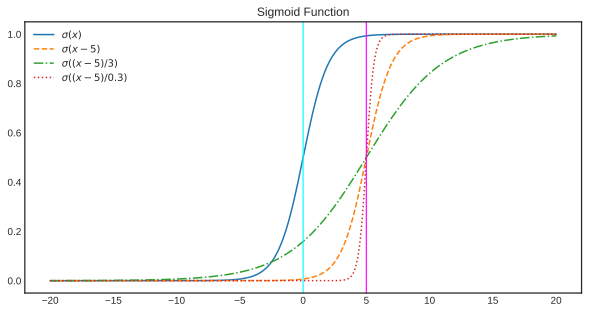

In [9]:
#@title **Make Demo Figure: `Sigmoid Function`**
#@markdown 👉 Run this cell to generate the figure.

import matplotlib.pyplot as plt

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' # 'svg', 'retina' 
plt.style.use('seaborn-white')

def make_figure(figtitle: str="Sigmoid Function"):
    """Make the demo figure for using sigmoid."""

    x = np.arange(-20, 20.01, 0.01)
    y1 = sigmoid(x)
    y2 = sigmoid(x - 5)
    y3 = sigmoid((x - 5)/3)
    y4 = sigmoid((x - 5)/0.3)
    fig, ax = plt.subplots(figsize=(10,5))
    plt.sca(ax)
    plt.plot(x, y1, ls="-", label="$\sigma(x)$")
    plt.plot(x, y2, ls="--", label="$\sigma(x - 5)$")
    plt.plot(x, y3, ls="-.", label="$\sigma((x - 5) / 3)$")
    plt.plot(x, y4, ls=":", label="$\sigma((x - 5) / 0.3)$")
    plt.axvline(x=0, ls="-", lw=1.3, color="cyan", alpha=0.9)
    plt.axvline(x=5, ls="-", lw=1.3, color="magenta", alpha=0.9)
    plt.legend()
    plt.title(figtitle)
    plt.show()

make_figure()

In [10]:
def myFunc3(params):
    """myFunc metric v3 with smoother metric."""
    (ev, bv, vc, dv) = params
    df['Number'] = sigmoid(x = -(df['Dividend2'] - vc)) * 1 \
                    + sigmoid(x = -(df['EV2'] - dv)) * 1
    df['Return'] = (
        sigmoid(x = df['EV'] - ev) 
        * sigmoid(x = -(df['Probability'] - bv))
        * sigmoid(x = df['Number'] * df['Dividend'] - (vc + dv))
    )
    return -1 * (df['Return'].sum())

**Let's run the optimization with `myFunc3`**.

In [11]:
b1 = [(0.2,4), (300,600), (0,1000), (0,1000)]
start = [0.2, 600, 1000, 1000]
result = optimize.minimize(fun=myFunc3, bounds=b1, x0=start)
print(result)

      fun: -9.205744996521235e-214
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.80549319e-214, 0.00000000e+000, 9.20564761e-214, 9.20564761e-214])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 0
   status: 0
  success: True
        x: array([2.e-01, 6.e+02, 1.e+03, 1.e+03])


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


💡 So, the attempt to use a smoother metric did not work straight out of the box. May be some tinkering with it will lead to something useful. But for now, we will progress without any smoother version of `myFunc`.

## **Brute-forcing the Discovery of the Loss-Landscape**

If we choose some possible values for each of the four parameters `ev, bv, vc, dv`; create a grid of those search parameters, and use these to evaluate the metric `myFunc2` instead of `myFunc` (as the former does fewer steps than latter), we could then potentially plot the loss-landscape and see how it changes with the changing values of the four parameters.

This will help us gain some insight into what kind of loss-landscape we have at hand.

In [12]:
(ev, bv, vc, dv) = [0.2, 600, 1000, 1000]

In [ ]:
b1 = [(0.2,4), (300,600), (0,1000), (0,1000)]
start = [0.2, 300, 500, 200]
result = optimize.minimize(fun=myFunc3, bounds=b1, x0=start, method="L-BFGS-B")
print(result)

      fun: 4.682490048005353e-16
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.95840764e-16,  4.68249374e-16,  9.09221358e-19,  9.09221358e-19])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 5
      nit: 0
   status: 0
  success: True
        x: array([2.e-01, 3.e+02, 5.e+02, 2.e+02])


/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

overflow encountered in exp



In [ ]:
grid = [np.linspace(start=low, stop=high, num=10, endpoint=True) for (low, high) in b1]

In [261]:
def make_param_grid(
        bounds: List[Tuple[float, float]], 
        param_names: Optional[List[str]]=None, 
        num_points: int=10, 
        as_dict: bool=True,
    ) -> Union[pd.DataFrame, Dict[str, List[float]]]:
    """
    Create parameter search space.

    Example:
    
        grid = make_param_grid(bounds=b1, num_points=10, as_dict=True)
    
    """
    if param_names is None:
        param_names = PARAM_NAMES # ["ev", "bv", "vc", "dv"]
    bounds = np.array(bounds)
    grid = np.linspace(start=bounds[:,0], 
                       stop=bounds[:,1], 
                       num=num_points, 
                       endpoint=True, 
                       axis=0)
    grid = pd.DataFrame(grid, columns=param_names)
    if as_dict:
        grid = grid.to_dict()
        for k,v in grid.items():
            grid.update({k: list(v.values())})
    return grid

In [263]:
grid = make_param_grid(bounds=b1, num_points=10, as_dict=True)

In [258]:
# grid

In [248]:
bounds = np.array(b1)
grid = np.linspace(start=bounds[:,0], stop=bounds[:,1], num=10, endpoint=True, axis=0)
df_grid = pd.DataFrame(grid, columns=["ev", "bv", "vc", "dv"])
df_grid

,ev,bv,vc,dv
0,0.200000,300.000000,0.000000,0.000000
1,0.622222,333.333333,111.111111,111.111111
2,1.044444,366.666667,222.222222,222.222222
3,1.466667,400.000000,333.333333,333.333333
4,1.888889,433.333333,444.444444,444.444444
5,2.311111,466.666667,555.555556,555.555556
6,2.733333,500.000000,666.666667,666.666667
7,3.155556,533.333333,777.777778,777.777778
8,3.577778,566.666667,888.888889,888.888889
9,4.000000,600.000000,1000.000000,1000.000000


In [41]:
from tqdm.notebook import tqdm
import time

In [42]:
for i in tqdm(range(5), desc="Looping..."):
    time.sleep(1)

Looping...:   0%|          | 0/5 [00:00<?, ?it/s]

In [171]:
import gc
from typing import Dict, List, Tuple, Union, Optional, Any, Iterable, Callable

from tqdm.notebook import tqdm
# from tqdm.auto import tqdm  # for notebooks
# source: https://stackoverflow.com/questions/18603270/progress-indicator-during-pandas-operations

BoundsItemType = Tuple[float, float]
ParamNamesType = List[str]
BoundsItemsDict = Dict[str, BoundsItemType]

PARAM_NAMES: ParamNamesType = ["ev", "bv", "vc", "dv",]
DEFAULT_METRIC_FUNC: Callable = myFunc2

def eval_metric(params: Dict[str, float], 
                func: Optional[Callable]=None, 
                param_names: Optional[List[str]]=None) -> float:
    """
    Evaluate a metric with a parameter-dictionary (``param``) 
    and a function (``func``).
    """
    if param_names is None:
        param_names = PARAM_NAMES
    if func is None:
        func = DEFAULT_METRIC_FUNC
    return func((params[p] for p in param_names))


def prepare_bounds(
        bounds: List[BoundsItemType], 
        param_names: Optional[ParamNamesType]=None
    ) -> BoundsItemsDict:
    """Prepare bounds from a List of Tuples to."""
    if param_names is None:
        param_names = PARAM_NAMES
    if not isinstance(bounds, dict):
        bounds = dict((p, (min(b), max(b))) 
                        for p, b in zip(param_names, bounds))
    return bounds


class SearchGrid:
    """SearchGrid class."""

    param_grid: pd.DataFrame
    search_grid: pd.DataFrame

    def __init__(self, bounds: Dict[str, Tuple[float, float]]):
        """Instatiate SearchGrid with parameter bounds."""
        self.bounds = bounds        

    def __repr__(self):
        return f"{self.__class__.__name__} class"

    def create_param_grid(self, num_points: int=10, inplace: bool=True):
        """Create parameter grid with values from parameter bounds."""
        self.param_grid = pd.DataFrame(
            dict(
                (k, np.linspace(start=low, stop=high, 
                                num=num_points, endpoint=True)
                ) 
                for k, (low, high) in bounds.items()
            )
        )
        if inplace:
            return self        

    def create_search_grid(self,
            param_grid: Optional[pd.DataFrame]=None, 
            verbose: bool=True,
            inplace: bool=False,
        ):
        """Create search grid with values from parameter grid."""
        if param_grid is None:
            param_grid = self.param_grid.copy()
        nrows, ncols = param_grid.shape

        search_grid = []

        with tqdm(total = nrows * ncols, desc="Creating...") as pbar:
            for ev in param_grid["ev"]:
                for bv in param_grid["bv"]:
                    for vc in param_grid["vc"]:
                        for dv in param_grid["dv"]:
                            search_grid.append(
                                {"ev": ev, "bv": bv, "vc": vc, "dv": dv}
                            )
                            pbar.update(1) # update pbar for every search config
        self.search_grid = pd.DataFrame(search_grid)
        search_grid = None; gc.collect()
        if verbose:
            print(f"search-grid-shape: {self.search_grid.shape}")
        if inplace:
            return self

    def save(self, 
            filepath: str="search_grid", 
            data: Optional[pd.DataFrame]=None, 
            method: str="parquet"
        ):
        if data is None:
            data = self.search_grid.copy()
        if method == "parquet":
            ext = "parquet"
            data.to_parquet(f"{filepath}.{ext}")

    def transform(self, func: Callable, column: str="returns", 
                  show_progressbar: bool=True, inplace: bool=False):
        if show_progressbar:
            tqdm.pandas(desc="Transforming")
            self.search_grid[column] = self.search_grid.progress_apply(
                                            func=lambda row: func(row.tolist()), 
                                            axis=1)
        else:
            self.search_grid[column] = self.search_grid.apply(
                                            func=lambda row: func(row.tolist()), 
                                            axis=1)
        if inplace:
            return self



In [55]:
bounds = prepare_bounds(bounds=b1)
bounds

{'bv': (300, 600), 'dv': (0, 1000), 'ev': (0.2, 4), 'vc': (0, 1000)}

In [62]:
sg = SearchGrid(bounds = bounds)

In [63]:
sg.create_param_grid(num_points=10, inplace=False)

In [64]:
sg.create_search_grid(inplace=False)

Creating...:   0%|          | 0/40 [00:00<?, ?it/s]

search-grid-shape: (10000, 4)


In [65]:
pd.__version__

'1.3.5'

In [66]:
sg.transform(func=myFunc2, column="returns", inplace=False)

Transforming:   0%|          | 0/10000 [00:00<?, ?it/s]

In [70]:
sg.save(method="parquet")

In [67]:
gc.collect()

176

In [68]:
sg.search_grid.shape

(10000, 5)

In [56]:
sg.param_grid["ev"]

0    0.200000
1    0.622222
2    1.044444
3    1.466667
4    1.888889
5    2.311111
6    2.733333
7    3.155556
8    3.577778
9    4.000000
Name: ev, dtype: float64

In [ ]:
df_search_grid.shape

(10000, 4)

In [ ]:
df_search_grid["return"] = df_search_grid.apply(func= lambda row: myFunc2(row.tolist()), axis=1)

In [ ]:
df_search_grid.to_parquet("search_grid_results.parquet")

In [283]:
import plotly.express as px

In [284]:
def make_hiplot(search_grid: pd.DataFrame, num_smallest: Optional[int]=None, column: str="returns"):
    search_grid = search_grid if (num_smallest is None) else (
        search_grid
            .loc[ sg.search_grid[column]
                    .nsmallest( n=np.abs(num_smallest), 
                                keep="first")
                    .index]
    )
    fig = px.parallel_coordinates(
        search_grid, 
        color=column, 
        color_continuous_scale=px.colors.diverging.Tealrose,
        # color_continuous_midpoint=2,
    )
    fig.show()
    return fig

In [285]:
fig = make_hiplot(sg.search_grid, num_smallest=None, column="returns")

In [282]:
import kaleido
import plotly

In [286]:
fig.write_image("fig_SearchGrid_all.png")

ValueError: ignored

In [73]:
sg.search_grid.loc[sg.search_grid["returns"].argmin()]

ev           0.200000
bv         466.666667
vc         222.222222
dv           0.000000
returns    -88.333333
Name: 520, dtype: float64

In [74]:
myFunc2((0.20, 466.667, 222.22, 0.00))

-88.33999999999997

In [287]:
fig2 = make_hiplot(sg.search_grid, num_smallest=50, column="returns")

In [75]:
fig = px.parallel_coordinates(
    sg.search_grid.loc[sg.search_grid["returns"].nsmallest(n=50, keep="first").index], 
    color="returns", 
    color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=2,
)
fig.show()

In [77]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
# source: https://plotly.com/python/3d-surface-plots/

In [78]:
x, y = "dv", "vc"
# x = y = np.arange(100)
df_target = sg.search_grid.drop_duplicates(subset=[x, y, "returns"])
# fig = go.Figure(data=[go.Surface(z=(np.c_[x**2] + np.r_[y**2] + np.c_[x]*np.r_[y**0.67])**0.5, x=x, y=y)])
fig = go.Figure(data=[go.Surface(z=df_target["returns"],)])
fig.update_layout(title='Return Maximization', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [79]:
sg.search_grid.drop_duplicates(subset=["dv", "vc", "returns"]).shape

(397, 5)

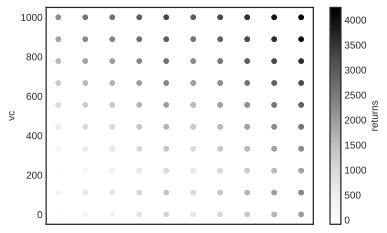

In [80]:
df_target.plot(kind="scatter", x=x, y=y, c="returns")

## Using Optuna for Optimizing the Loss Landscape

In [81]:
%%capture
! pip install -Uqq optuna

In [269]:
import optuna
import warnings
from functools import partial
from typing import Iterable, Optional, Callable, List

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)
optuna.logging.set_verbosity(optuna.logging.WARNING)

PARAM_NAMES: List[str] = ["ev", "bv", "vc", "dv",]
DEFAULT_METRIC_FUNC: Callable = myFunc2

def objective(trial, 
              bounds: Optional[Iterable]=None, 
              func: Optional[Callable]=None, 
              param_names: Optional[List[str]]=None):
    if param_names is None:
        param_names = PARAM_NAMES
    if (bounds is None):
        bounds = ((-10, 10) for _ in param_names)
    if not isinstance(bounds, dict):
        bounds = dict((p, (min(b), max(b))) 
                        for p, b in zip(param_names, bounds))
    if func is None:
        func = DEFAULT_METRIC_FUNC

    params = dict(
        (p, trial.suggest_float(p, bounds.get(p)[0], bounds.get(p)[1])) 
        for p in param_names        
    )
    # x = trial.suggest_float('x', -10, 10)
    return func((params[p] for p in param_names))

def optimize(objective: Callable, 
             sampler: Optional[optuna.samplers.BaseSampler]=None, 
             func: Optional[Callable]=None, 
             n_trials: int=2, 
             study_direction: str="minimize",
             study_name: Optional[str]=None,
             formatstr: str=".4f",
             verbose: bool=True):
    if func is None:
        func = DEFAULT_METRIC_FUNC
    study = optuna.create_study(
        direction=study_direction, 
        sampler=sampler, 
        study_name=study_name)
    study.optimize(
        objective, 
        n_trials=n_trials, 
        show_progress_bar=True, 
        n_jobs=1,
    )
    if verbose:
        metric = eval_metric(study.best_params, func=myFunc2)
        msg = format_result(study.best_params, metric, 
                            header=study.study_name, 
                            format=formatstr)
        print(msg)
    return study

def format_dict(d: Dict[str, float], format: str=".4f") -> Dict[str, float]:
    return dict((k, float(f'{v:{format}}')) for k,v in d.items())

def format_result(d: Dict[str, float], 
                  metric_value: float, 
                  header: str='', 
                  format: str=".4f"): 
    """Returns formatted result."""
    msg = f"""Study Name: {header}\n{'='*30}
    
    ✅ study.best_params: \n\t{format_dict(d)}
    ✅ metric: {metric_value} 
    """
    return msg


b1 = [(0.2,4), (300,600), (0,1000), (0,1000)]
param_names = ["ev", "bv", "vc", "dv",]
pobjective = partial(objective, bounds=b1)

# study = optuna.create_study(direction="minimize")
# study.optimize(pobjective, n_trials=100, show_progress_bar=True, n_jobs=1,)

# study.best_params  # E.g. {'x': 2.002108042}

In [205]:
format_dict(d=studies["test"].best_params)

{'bv': 374.221, 'dv': 151.3849, 'ev': 3.9663, 'vc': 523.5604}

In [186]:
studies = dict()

In [234]:
studies["test"] = optimize(pobjective, n_trials=2, study_name="test")

  0%|          | 0/2 [00:00<?, ?it/s]

Study Name: test
    
    ✅ study.best_params: 
	{'ev': 2.596, 'bv': 514.6414, 'vc': 674.7666, 'dv': 465.9252}
    ✅ metric: -0.0 
    


In [180]:
out = dict((k, f"{v: .4f}") for k,v in studies["test"].best_params.items())
print(f'best_params: \n\t{out}')

best_params: 
	{'ev': ' 1.7554', 'bv': ' 549.1136', 'vc': ' 37.3300', 'dv': ' 240.4165'}


In [226]:
study.study_name

'no-name-2b2d0417-3093-4b23-ad24-505705c73867'

In [174]:
eval_metric(studies["test"].best_params, func=myFunc2)

-0.0

In [115]:
myFunc2((0.22, 423.823, 185.00, 139.00))

408.0

In [235]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=42)

# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(pobjective, n_trials=100, show_progress_bar=True, n_jobs=1,)
# study.best_params  # E.g. {'x': 2.002108042}
study_name = "TPESampler"
studies[study_name] = optimize(
    pobjective, 
    sampler=sampler, 
    n_trials=100, 
    study_name=study_name,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Study Name: TPESampler
    
    ✅ study.best_params: 
	{'ev': 1.6233, 'bv': 585.2143, 'vc': 731.9939, 'dv': 598.6585}
    ✅ metric: -0.0 
    


In [ ]:
# Study Name: GridSampler
# ==============================
#    
#     ✅ study.best_params: 
# 	{'ev': 0.2, 'bv': 500.0, 'vc': 222.2222, 'dv': 0.0}
#     ✅ metric: -88.33333333333337 

In [239]:
eval_metric(studies["TPESampler"].best_params, func=myFunc2)

-0.0

In [241]:
from optuna.samplers import GridSampler

search_space = sg.param_grid.to_dict()
for k,v in search_space.items():
    search_space.update({k: list(v.values())})

sampler = GridSampler(search_space)

study_name = "GridSampler"
studies[study_name] = optimize(
    pobjective, 
    sampler=sampler, 
    n_trials=2000, 
    study_name=study_name,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

Study Name: GridSampler
    
    ✅ study.best_params: 
	{'ev': 0.2, 'bv': 500.0, 'vc': 222.2222, 'dv': 0.0}
    ✅ metric: -88.33333333333337 
    


In [242]:
eval_metric(studies["GridSampler"].best_params, func=myFunc2)

-88.33333333333337

In [237]:
from optuna.samplers import RandomSampler

sampler = RandomSampler(seed=42)

# study = optuna.create_study(direction="minimize", sampler=sampler)
# study.optimize(pobjective, n_trials=300, show_progress_bar=True, n_jobs=1,)
# study.best_params  # E.g. {'x': 2.002108042}

study_name = "RandomSampler"
studies[study_name] = optimize(
    pobjective, 
    sampler=sampler, 
    n_trials=300, 
    study_name=study_name,
)

  0%|          | 0/300 [00:00<?, ?it/s]

Study Name: RandomSampler
    
    ✅ study.best_params: 
	{'ev': 1.6233, 'bv': 585.2143, 'vc': 731.9939, 'dv': 598.6585}
    ✅ metric: -0.0 
    


In [ ]:
# Study Name: RandomSampler
# ==============================
#    
#     ✅ study.best_params: 
# 	{'ev': 1.6233, 'bv': 585.2143, 'vc': 731.9939, 'dv': 598.6585}
#     ✅ metric: -0.0 

In [219]:
eval_metric(studies["RandomSampler"].best_params, func=myFunc2)

-0.0

In [ ]:
# n_trials = 400
# best_params:
# {'bv': 375.38574057146155,
#  'dv': 58.536787420517044,
#  'ev': 2.4587282949361096,
#  'vc': 362.2398381472226}
#
# return: -0.0

# n_trials = 800
# best_params:
# {'bv': 460.40113576177407,
#  'dv': 10.269342431643015,
#  'ev': 3.950558995545498,
#  'vc': 574.7203257102416}
#
# return: -0.0

In [ ]:
myFunc2((3.951, 460.401, 574.720, 10.269))

-0.0

In [270]:
def study_contour_plot(study: optuna.Study, 
                       params: Optional[List[str]]=None, 
                       width: int=560, 
                       height: int=500):
    """
    Create contour plots for a study, given a list or 
    tuple of two parameter names.
    """
    if params is None:
        params = ["dv", "vc"]
    fig = optuna.visualization.plot_contour(study, params=params)
    fig.update_layout(
        title=f'Contour Plot: {study.study_name} ({params[0]}, {params[1]})', 
        autosize=False,
        width=width, 
        height=height,
        margin=dict(l=65, r=50, b=65, t=90))
    fig.show()

In [268]:
study_name = "GridSampler"
study = studies.get(study_name)

views = [("dv", "vc"), ("dv", "bv"), ("dv", "ev"), 
         ("bv", "ev"), ("vc", "ev"), ("vc", "bv")]

for i, (x, y) in enumerate(views):
    print(f"Figure: {i}/{len(views)}")
    study_contour_plot(study=study, params=(x, y))

Figure: 0/6


Figure: 1/6


Figure: 2/6


Figure: 3/6


Figure: 4/6


Figure: 5/6


In [122]:
fig = optuna.visualization.plot_contour(study, params=["dv", "bv"])
fig.update_layout(title='Contour Plot', autosize=False,
                  width=560, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [123]:
fig = optuna.visualization.plot_contour(study, params=["dv", "ev"])
fig.update_layout(title='Contour Plot', autosize=False,
                  width=560, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [271]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(title=f'Hyperparameter Importances: {study.study_name}', 
                  autosize=False,
                  width=800, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [127]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(title='Optimization History Plot', 
                  autosize=False,
                  width=800, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [109]:
fig = optuna.visualization.plot_slice(study, params=param_names)
fig.show()

In [243]:
fig = optuna.visualization.plot_edf([studies[x] for x in ['TPESampler', 'GridSampler', 'RandomSampler']])
fig.show()

In [223]:
studies.keys()

dict_keys(['test', 'TPESampler', 'GridSampler', 'RandomSampler'])